In [1]:
##############################################################################################################
# DESCRIPTION: 
# RESULTS:     
#              
##############################################################################################################

In [2]:
######################
# CONFIG & HYPERPARAMS
######################

import os

IMG_PATH = "C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/"

IMG_PATH_VALID = IMG_PATH + "validation/"
IMG_PATH_TEST = IMG_PATH + "test/"
IMG_PATH_TRAIN = IMG_PATH

class HyperParams:
    pass
hyperparams = HyperParams()

hyperparams.IMG_WIDTH = 64
hyperparams.IMG_HEIGHT = 64
hyperparams.EPOCHS = 120
hyperparams.BATCH_SIZE = 32

hyperparams.LOSS = 'mean_absolute_error'

IMG_WIDTH = hyperparams.IMG_WIDTH
IMG_HEIGHT = hyperparams.IMG_HEIGHT

IMG_CASE = str(IMG_WIDTH) +  "/0100_1000"
MODEL_NAME = "0100_1000-64-aeconnect-e4"

DEST_TESTS = os.path.abspath(os.path.join('../../../out_tests/', MODEL_NAME))

class RadianceLimits:
    pass
radiance_limits = RadianceLimits()
radiance_limits.noisy_min = 0
radiance_limits.noisy_max = 0.0898
radiance_limits.nitid_min = 0
radiance_limits.nitid_max = 0.3248

from tensorflow.keras.optimizers import Adam
hyperparams.OPTIMIZER = Adam(0.0005,beta_1=0.9)

In [3]:
##################
# IMPORTS
##################

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

import numpy as np
import tensorflow 
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)
import os, sys
module_path = os.path.abspath(os.path.join('../../support/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import DatasetUtilsTifF as dsutils
import TrainModelC as train
import ReportsK as reports
import AEConnectionsF as model_factory

In [4]:
##################
# MODEL DEFINITION
##################
model = model_factory.buildModel(hyperparams)
model.summary()
model.optimizer.get_config()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   18496       leaky_re_lu[0][0]                
______________________________________________________________________________________________

{'name': 'Adam',
 'learning_rate': 0.0005,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [5]:
##################
# PREPARE DATA
##################

train_noisy_files, train_nitid_files, train_noisy, train_nitid = dsutils.readDataset( IMG_PATH_TRAIN, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)
val_noisy_files, val_nitid_files, val_noisy, val_nitid = dsutils.readDataset( IMG_PATH_VALID, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

train_noisy, train_nitid = dsutils.reshapeDataset( train_noisy, train_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )
val_noisy, val_nitid = dsutils.reshapeDataset( val_noisy, val_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/
Noisy files:8886
Nitid files:8886
Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/validation/
Noisy files:2209
Nitid files:2209


In [6]:
##################
# TRAIN MODEL
##################
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)


hist = train.fit( model, hyperparams, train_noisy, train_nitid, val_noisy, val_nitid, patience = 30 )

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6

Epoch 1/120
278/278 [==============================] - 13s 28ms/step - loss: 0.0456 - val_loss: 0.0389
Epoch 2/120
278/278 [==============================] - 7s 25ms/step - loss: 0.0287 - val_loss: 0.0350
Epoch 3/120
278/278 [==============================] - 7s 25ms/step - loss: 0.0272 - val_loss: 0.0234
Epoch 4/120
278/278 [==============================] - 7s 25ms/step - loss: 0.0269 - val_loss: 0.0250
Epoch 5/120
278/278 [==============================] - 7s 25ms/step - loss: 0.0257 - val_loss: 0.0328
Epoch 6/120
278/278 [==============================] - 7s 25ms/step - loss: 0.0255 - val_loss: 0.0234
Epoch 7/120
278/278 [==============================] - 7s 25ms/step - loss: 0.0247 - val_loss: 0.0252
Epoch 8/120
278/278 [==============================] - 7s 25ms/step - loss: 0.0241 - val_loss: 0.0242
Epoch 9/120
278/278 [==

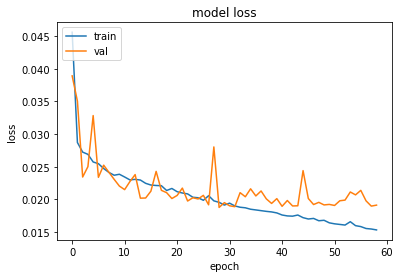

In [7]:
##################
# REPORTS
##################
reports.plotHistory( hist )

In [8]:
##################
# PREDICTIONS
##################
ACCURACY_THRESHOLD = 0.01
predictions_metrics, predictions_headers \
    = reports.calcPredictionMetrics( model, val_noisy, val_nitid, ACCURACY_THRESHOLD, \
                                    save_pred = True, save_path = DEST_TESTS, \
                                    noisy_files = val_noisy_files, nitid_files = val_nitid_files, \
                                    max_nitid= radiance_limits.nitid_max  )

Black image found
Black image found
Images count =2209
Best RMSENZ  =2066 (0.94)
Best MAENZ   =2070 (0.94)
Best Accuracy=1972 (0.89)
RMSE-NZ  Pred=0.0227  Noisy=0.0942
MAE-NZ   Pred=0.0191  Noisy=0.0903
PSNR     Pred=20.5 dB Noisy=9.3 dB
Accuracy Pred=0.41    Noisy=0.09
SSM      Pred=0.95    Noisy=0.66
HOG MSE  Pred=0.09    Noisy=0.12


In [9]:
model.save(os.path.abspath(os.path.join('../../../saves/', MODEL_NAME)), model)

INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0100_1000-64-aeconnect-e4\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test/
Noisy files:15
Nitid files:15
Index:0
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_13_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_13_nitid_idx134.tif


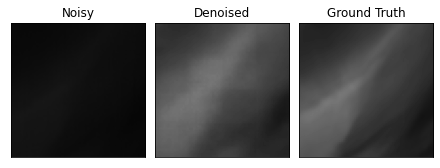

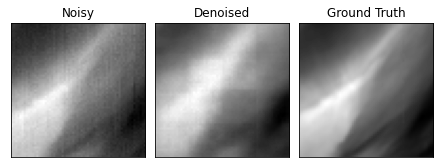

RMSE-NZ  Pred=0.0470  Noisy=0.2105 BEST
MAE-NZ   Pred=0.0410  Noisy=0.1954 BEST
PSNR     Pred=20.0 dB Noisy=6.9 dB BEST
Accuracy Pred=0.09    Noisy=0.00 BEST
SSM      Pred=0.94    Noisy=0.31
HOG MSE  Pred=0.07    Noisy=0.13
******************************************************
Index:1
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_14_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_14_nitid_idx134.tif


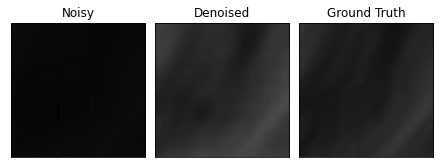

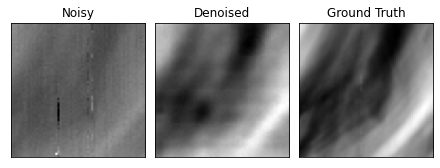

RMSE-NZ  Pred=0.0511  Noisy=0.0994 BEST
MAE-NZ   Pred=0.0487  Noisy=0.0953 BEST
PSNR     Pred=12.7 dB Noisy=7.0 dB BEST
Accuracy Pred=0.01    Noisy=0.00 BEST
SSM      Pred=0.93    Noisy=0.34
HOG MSE  Pred=0.04    Noisy=0.16
******************************************************
Index:2
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_01_00_0_noisy_idx014.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_01_00_0_nitid_idx017.tif


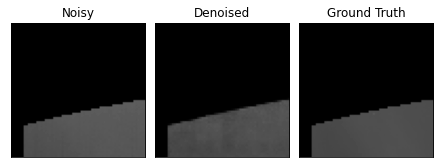

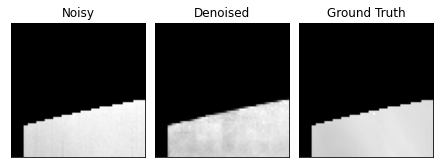

RMSE-NZ  Pred=0.0141  Noisy=0.0388 BEST
MAE-NZ   Pred=0.0050  Noisy=0.0376 BEST
PSNR     Pred=27.8 dB Noisy=19.0 dB BEST
Accuracy Pred=0.82    Noisy=0.00 BEST
SSM      Pred=0.97    Noisy=0.97
HOG MSE  Pred=0.19    Noisy=0.07
******************************************************
Index:3
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0317_03_01_4_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0317_03_01_4_nitid_idx017.tif


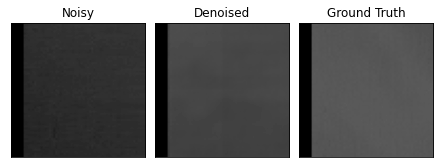

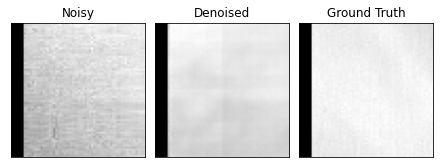

RMSE-NZ  Pred=0.0683  Noisy=0.1632 BEST
MAE-NZ   Pred=0.0630  Noisy=0.1622 BEST
PSNR     Pred=14.5 dB Noisy=6.9 dB BEST
Accuracy Pred=0.09    Noisy=0.00 BEST
SSM      Pred=0.95    Noisy=0.87
HOG MSE  Pred=0.00    Noisy=0.01
******************************************************
Index:4
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0318_03_02_4_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0318_03_02_4_nitid_idx134.tif


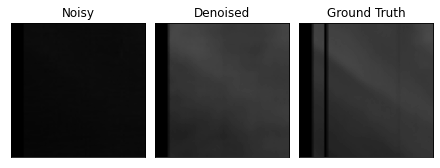

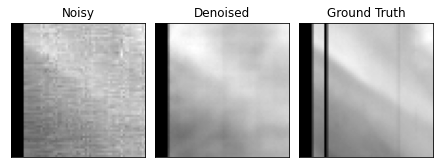

RMSE-NZ  Pred=0.0305  Noisy=0.1704 BEST
MAE-NZ   Pred=0.0118  Noisy=0.1661 BEST
PSNR     Pred=19.5 dB Noisy=4.6 dB BEST
Accuracy Pred=0.68    Noisy=0.00 BEST
SSM      Pred=0.88    Noisy=0.33
HOG MSE  Pred=0.04    Noisy=0.07
******************************************************
Index:5
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0318_03_02_5_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0318_03_02_5_nitid_idx134.tif


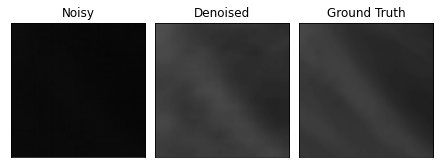

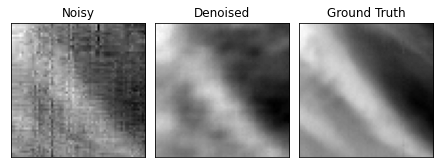

RMSE-NZ  Pred=0.0214  Noisy=0.1649 BEST
MAE-NZ   Pred=0.0195  Noisy=0.1619 BEST
PSNR     Pred=22.3 dB Noisy=4.6 dB BEST
Accuracy Pred=0.15    Noisy=0.00 BEST
SSM      Pred=0.97    Noisy=0.31
HOG MSE  Pred=0.11    Noisy=0.35
******************************************************
Index:6
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0332_00_01_12_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0332_00_01_12_nitid_idx017.tif


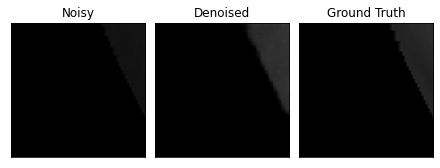

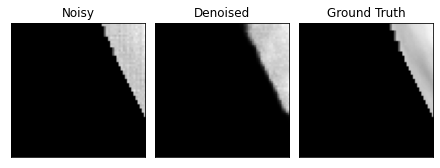

RMSE-NZ  Pred=0.0168  Noisy=0.0366 BEST
MAE-NZ   Pred=0.0058  Noisy=0.0184 BEST
PSNR     Pred=20.8 dB Noisy=14.0 dB BEST
Accuracy Pred=0.86    Noisy=0.74 BEST
SSM      Pred=0.97    Noisy=0.91
HOG MSE  Pred=0.12    Noisy=0.02
******************************************************
Index:7
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0332_00_02_5_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0332_00_02_5_nitid_idx134.tif


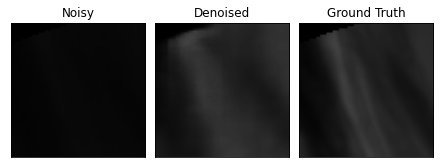

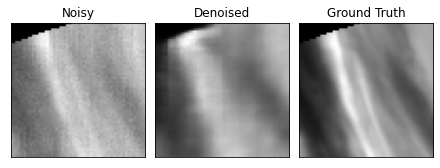

RMSE-NZ  Pred=0.0213  Noisy=0.1089 BEST
MAE-NZ   Pred=0.0174  Noisy=0.0979 BEST
PSNR     Pred=21.5 dB Noisy=7.3 dB BEST
Accuracy Pred=0.31    Noisy=0.01 BEST
SSM      Pred=0.90    Noisy=0.36
HOG MSE  Pred=0.08    Noisy=0.13
******************************************************
Index:8
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0343_03_01_8_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0343_03_01_8_nitid_idx017.tif


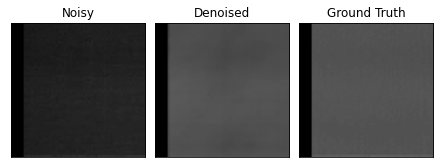

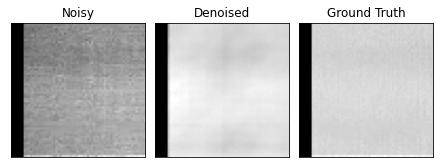

RMSE-NZ  Pred=0.0187  Noisy=0.1952 BEST
MAE-NZ   Pred=0.0139  Noisy=0.1947 BEST
PSNR     Pred=26.4 dB Noisy=6.0 dB BEST
Accuracy Pred=0.46    Noisy=0.00 BEST
SSM      Pred=0.97    Noisy=0.64
HOG MSE  Pred=0.02    Noisy=0.02
******************************************************
Index:9
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_11_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_11_nitid_idx134.tif


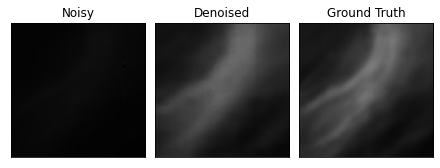

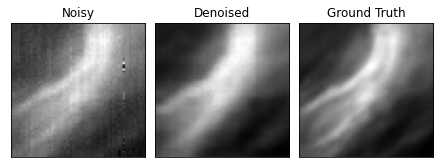

RMSE-NZ  Pred=0.0210  Noisy=0.1931 BEST
MAE-NZ   Pred=0.0161  Noisy=0.1660 BEST
PSNR     Pred=27.3 dB Noisy=8.0 dB BEST
Accuracy Pred=0.39    Noisy=0.00 BEST
SSM      Pred=0.93    Noisy=0.27
HOG MSE  Pred=0.03    Noisy=0.09
******************************************************
Index:10
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_12_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_12_nitid_idx134.tif


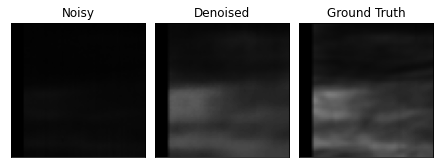

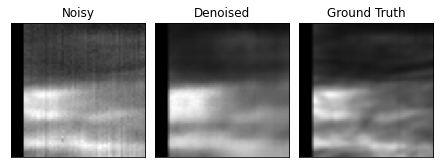

RMSE-NZ  Pred=0.0334  Noisy=0.1742 BEST
MAE-NZ   Pred=0.0227  Noisy=0.1438 BEST
PSNR     Pred=23.4 dB Noisy=9.1 dB BEST
Accuracy Pred=0.40    Noisy=0.00 BEST
SSM      Pred=0.93    Noisy=0.38
HOG MSE  Pred=0.02    Noisy=0.05
******************************************************
Index:11
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_13_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_13_nitid_idx134.tif


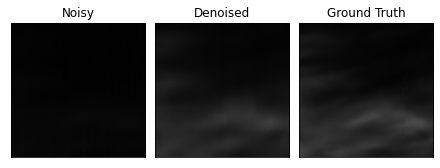

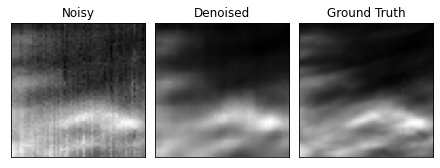

RMSE-NZ  Pred=0.0194  Noisy=0.0979 BEST
MAE-NZ   Pred=0.0136  Noisy=0.0772 BEST
PSNR     Pred=23.4 dB Noisy=9.4 dB BEST
Accuracy Pred=0.56    Noisy=0.04 BEST
SSM      Pred=0.96    Noisy=0.48
HOG MSE  Pred=0.03    Noisy=0.12
******************************************************
Index:12
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_03_11_noisy_idx157.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_03_11_nitid_idx146.tif


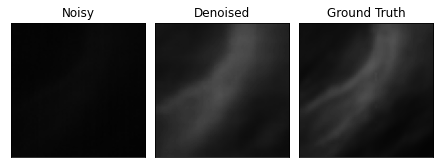

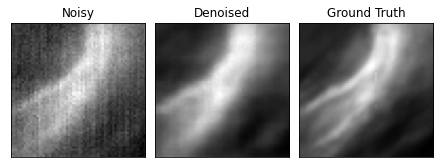

RMSE-NZ  Pred=0.0262  Noisy=0.1221 BEST
MAE-NZ   Pred=0.0227  Noisy=0.1019 BEST
PSNR     Pred=22.2 dB Noisy=8.8 dB BEST
Accuracy Pred=0.19    Noisy=0.02 BEST
SSM      Pred=0.92    Noisy=0.33
HOG MSE  Pred=0.03    Noisy=0.14
******************************************************
Index:13
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_03_8_noisy_idx157.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_03_8_nitid_idx146.tif


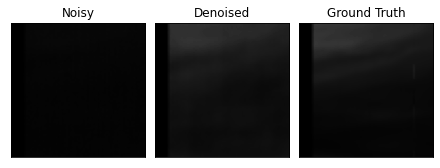

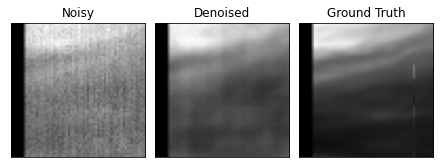

RMSE-NZ  Pred=0.0186  Noisy=0.0710 BEST
MAE-NZ   Pred=0.0147  Noisy=0.0512 BEST
PSNR     Pred=21.6 dB Noisy=10.0 dB BEST
Accuracy Pred=0.43    Noisy=0.21 BEST
SSM      Pred=0.89    Noisy=0.47
HOG MSE  Pred=0.07    Noisy=0.10
******************************************************
Index:14
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_05_02_0_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_05_02_0_nitid_idx134.tif


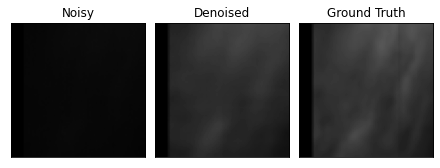

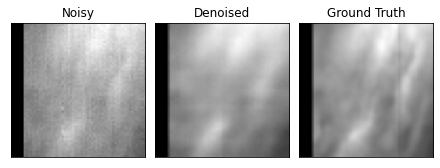

RMSE-NZ  Pred=0.0356  Noisy=0.1835 BEST
MAE-NZ   Pred=0.0321  Noisy=0.1780 BEST
PSNR     Pred=19.7 dB Noisy=5.5 dB BEST
Accuracy Pred=0.10    Noisy=0.00 BEST
SSM      Pred=0.93    Noisy=0.32
HOG MSE  Pred=0.03    Noisy=0.03
******************************************************


In [10]:
test_noisy_files, test_nitid_files, test_noisy, test_nitid = dsutils.readDataset( IMG_PATH_TEST, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)
test_noisy, test_nitid = dsutils.reshapeDataset( test_noisy, test_nitid,  hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )
test_indexes = np.arange(0,test_noisy.shape[0])

reports.predictByIndexes( model, test_noisy, test_nitid, test_noisy_files, test_nitid_files, test_indexes, ACCURACY_THRESHOLD )